In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploring the parameter space with HPO (hyperparameter optimisation)

Using NNI (Microsoft's Neural Network Intelligence framework for HPO), we have run experiments in which a number of parameters were varied in a defined search space. Here we are examining how much each parameter contributed to a change in the model.

## Imports

In [5]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('darkgrid')
sns.set_context('paper')
matplotlib.rcParams['font.family'] = "serif"

### Load the experiment summary

In [6]:
experiment_id = 'lmgbsj1e'
experiment_dir = os.path.join(os.path.expanduser('~'), 'nni-experiments', experiment_id)
experiment_log = os.path.join(experiment_dir, 'log', 'experiment.json')

with open(experiment_log) as f:
    log = json.load(f)

## Minor pre-processing

In [7]:
def reformat_data(bad_data: str):
    keys_values = bad_data.replace('"', '').replace(': ', '').replace(', ', '').strip('{}').split('\\')
    return {k: v for k, v in zip(keys_values[1::2], keys_values[2::2])}


def dictify_leafdict(innermost_dict: str):
    half_dict = innermost_dict.strip('{}').replace('"', '').split(',')
    return {v.split(':')[0]: v.split(':')[1] for v in half_dict}


def reformat_hyps(bad_hyps):
    hps = bad_hyps.strip('{}').split('{')
    parameters = dictify_leafdict(hps[1].split('}')[0])
    first_half_dict = hps[0].replace('"', '').split(',')
    secnd_half_dict = hps[1].replace('"', '').split('}')[-1].split(',')
    full_dict = dictify_leafdict(','.join(first_half_dict[:-1]))
    full_dict[first_half_dict[-1].split(':')[0]] = parameters
    full_dict.update(dictify_leafdict(','.join(secnd_half_dict[1:])))
    return full_dict


for i, triali in enumerate(log['trialMessage']):
    for j, trialj in enumerate(triali['finalMetricData']):
        log['trialMessage'][i]['finalMetricData'][j]['data'] = reformat_data(trialj['data'])
    for j, trialj in enumerate(triali['intermediate']):
        log['trialMessage'][i]['intermediate'][j]['data'] = reformat_data(trialj['data'])
    for j, trialj in enumerate(triali['hyperParameters']):
        log['trialMessage'][i]['hyperParameters'][j] = reformat_hyps(trialj)
            

## Construct table summary of trials

In [8]:
trial = log['trialMessage'][0]

parameters_cols = list(trial['hyperParameters'][0]['parameters'].keys())[1:]
parameters_dict = {k: [] for k in parameters_cols}

[[parameters_dict[k].append(np.float32(v)) for k, v in trial['hyperParameters'][0]
  ['parameters'].items() if k != 'filepath_data'] for trial in log['trialMessage']]
parameters_dict = {k: np.array(v) for k, v in parameters_dict.items()}

In [13]:
df = pd.DataFrame()

df['Trial'] = [trial['trialJobId'] for trial in log['trialMessage']]
df['Test accuracy'] = np.array([trial['finalMetricData'][0]['data']['default'] for trial in log['trialMessage']])
df['Test accuracy'] = df['Test accuracy'].apply(np.float32)
df['Train loss'] = np.array([trial['finalMetricData'][0]['data']['train_loss'] for trial in log['trialMessage']])
df['Train loss'] = df['Train loss'].apply(np.float32)
df['Test loss'] = np.array([trial['finalMetricData'][0]['data']['test_loss'] for trial in log['trialMessage']])
df['Test loss'] = df['Test loss'].apply(np.float32)
df['STD of Test accuracy'] = np.array([np.std([np.float32(i['data']['default']) for i in trial['intermediate']][1:]) for trial in log['trialMessage']])

df = pd.concat([df, pd.DataFrame.from_dict(parameters_dict)], axis=1)
df

,Trial,Test accuracy,Train loss,Test loss,STD of Test accuracy,batch_size,seed,steps,n_batches,linear_out1,linear_out2,conv2d_ks,conv2d_out_channels
0,pu1Ed,0.556495,1.278215,0.948678,0.003461,64.0,2.0,5000.0,1000.0,512.0,128.0,2.0,1.0
1,pLiOu,0.576094,1.372679,1.043352,0.000000,64.0,0.0,1000.0,1000.0,128.0,512.0,3.0,1.0
2,ztBZr,0.568120,1.142760,0.896555,0.016847,64.0,0.0,5000.0,1000.0,1024.0,512.0,1.0,3.0
3,BNWgP,0.569955,0.792000,0.899009,0.007954,128.0,1.0,1000.0,1000.0,128.0,512.0,2.0,1.0
4,A7U6p,0.566208,0.699867,0.837876,0.017126,128.0,2.0,5000.0,10000.0,256.0,512.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,piGOl,0.572632,0.919544,0.852949,0.005262,64.0,2.0,1000.0,10000.0,512.0,256.0,1.0,3.0
1587,bAkog,0.579524,0.897039,0.888931,0.005521,64.0,2.0,1000.0,10000.0,512.0,256.0,2.0,1.0
1588,LrSKB,0.579096,0.906007,0.868011,0.009999,64.0,2.0,1000.0,10000.0,512.0,256.0,2.0,3.0
1589,sBrfz,0.579272,1.106406,0.976409,0.006030,64.0,2.0,1000.0,10000.0,512.0,256.0,3.0,1.0


## Examining error of trials 

We can now use the table constructed above to examine the joint effect of different variables

Text(0.5, 1.0, 'Trials with STD > 0.04')

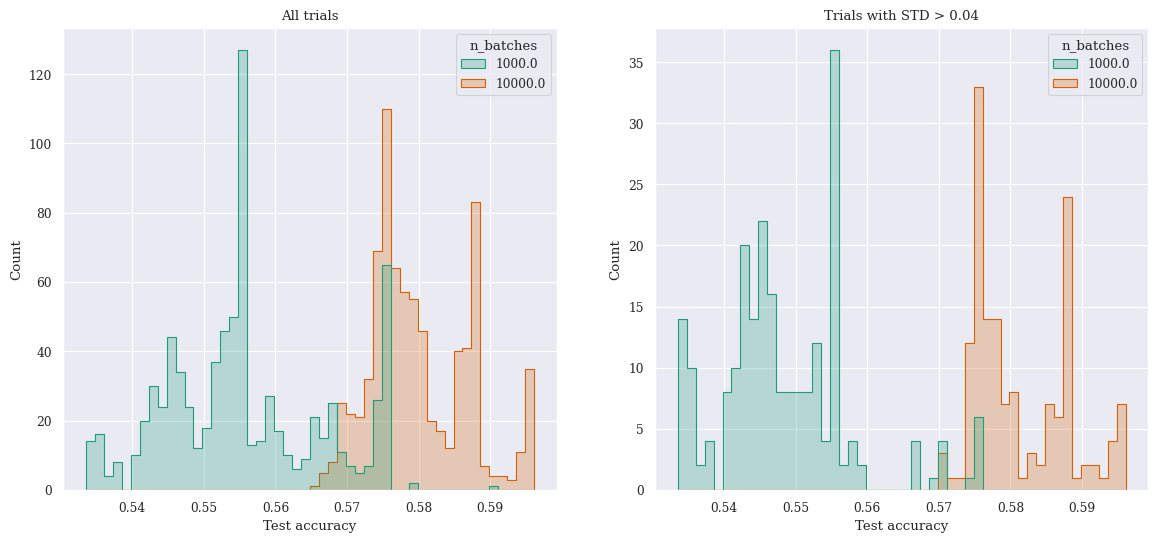

In [31]:
plt.figure(figsize=(7*2, 6))
ax = plt.subplot(1,2,1)
sns.histplot(df, x='Test accuracy', hue='n_batches', element='step', palette='Dark2', bins=50)
plt.title('All trials')
ax = plt.subplot(1,2,2)
l = 0.04
sns.histplot(df[df['STD of Test accuracy'] > l], x='Test accuracy', hue='n_batches', element='step', palette='Dark2', bins=50)
plt.title(f'Trials with STD > {l}')

Text(0.5, 0.98, 'Loss vs. Accuracy')

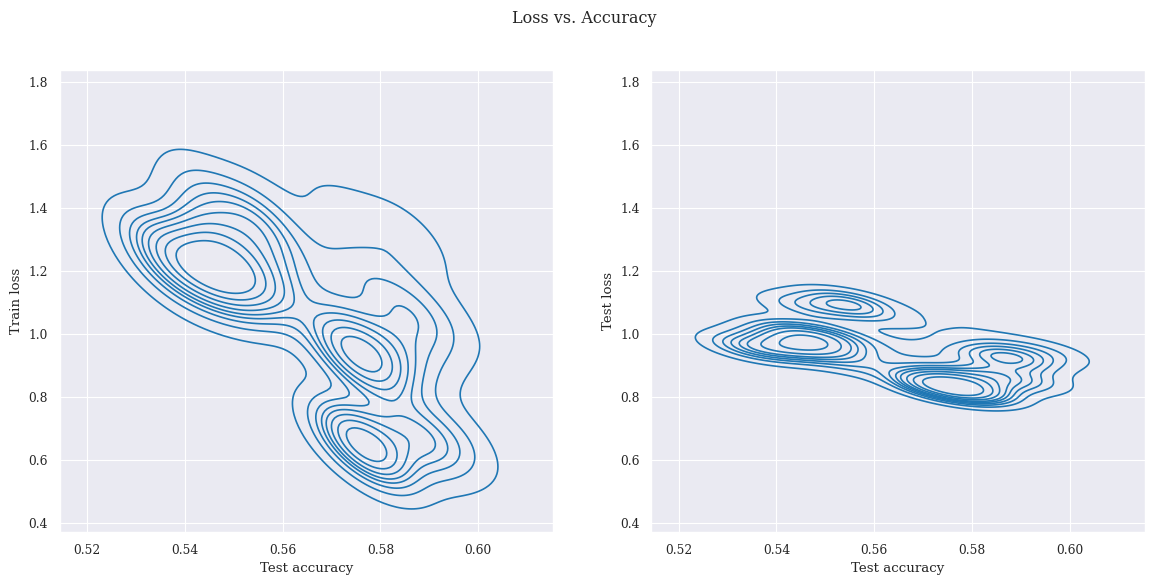

In [23]:
plt.figure(figsize=(7*2, 6))
ax1 = plt.subplot(1,2,1)
sns.kdeplot(df[df['STD of Test accuracy'] > 0.025], x='Test accuracy', y='Train loss')
ax2 = plt.subplot(1,2,2)
sns.kdeplot(df[df['STD of Test accuracy'] > 0.025], x='Test accuracy', y='Test loss')
ax2.set_ylim(*ax1.get_ylim())

plt.suptitle('Loss vs. Accuracy')